<AxesSubplot: title={'center': 'Unemployment rate'}, xlabel='Date'>

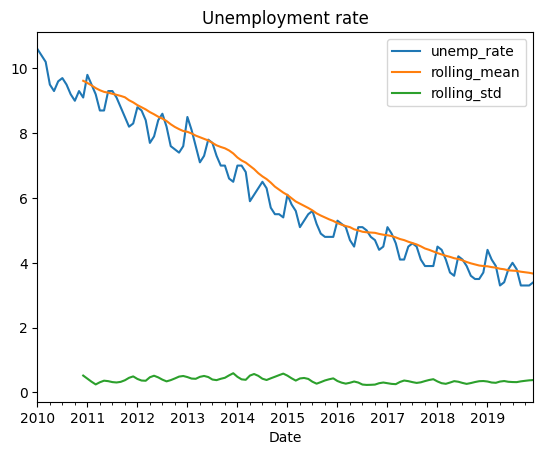

In [1]:
#Time Series Analysis and Forecasting
#Time series decomposition
import pandas as pd
import nasdaqdatalink
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
nasdaqdatalink.ApiConfig.api_key = "uLwMFhygQHyTJGEJ6QM3"
df = (
 nasdaqdatalink.get(dataset="FRED/UNRATENSA",
 start_date="2010-01-01",
 end_date="2019-12-31")
 .rename(columns={"Value": "unemp_rate"})
)
WINDOW_SIZE = 12
df["rolling_mean"] = df["unemp_rate"].rolling(window=WINDOW_SIZE).mean()
df["rolling_std"] = df["unemp_rate"].rolling(window=WINDOW_SIZE).std()
df.plot(title="Unemployment rate")

Text(0.5, 0.98, 'Additive Decomposition')

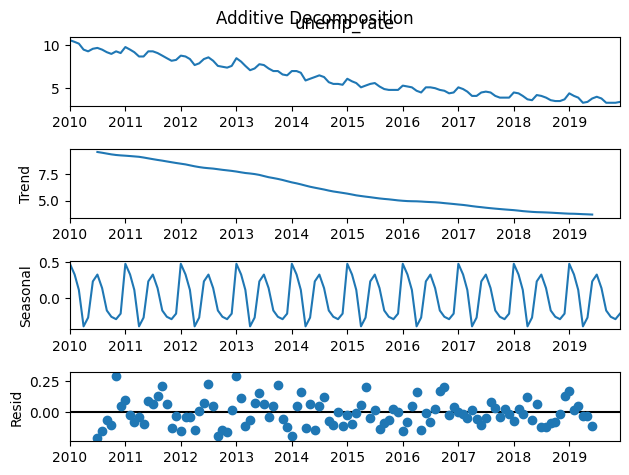

In [2]:
decomposition_results = seasonal_decompose(df["unemp_rate"],
 model="additive")
(
 decomposition_results
 .plot()
 .suptitle("Additive Decomposition")
)

Text(0.5, 0.98, 'STL Decomposition')

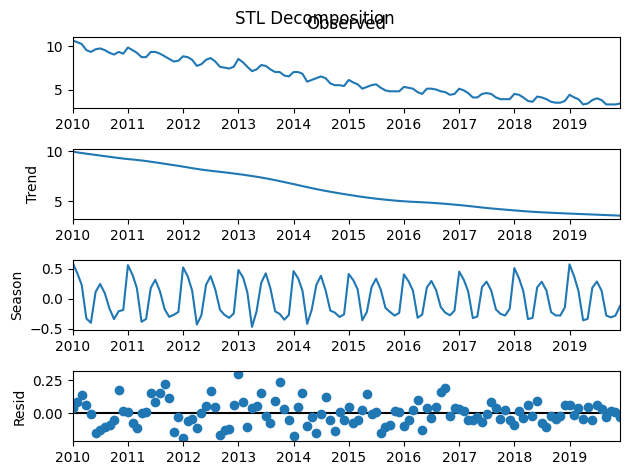

In [3]:
from statsmodels.tsa.seasonal import STL
stl_decomposition = STL(df[["unemp_rate"]]).fit()
stl_decomposition.plot() \
 .suptitle("STL Decomposition")

In [4]:
#Testing for stationarity in time series
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(x):
    indices = ["Test Statistic", "p-value",
 "# of Lags Used", "# of Observations Used"]
 
    adf_test = adfuller(x, autolag="AIC")
    results = pd.Series(adf_test[0:4], index=indices)
 
    for key, value in adf_test[4].items():
         results[f"Critical Value ({key})"] = value
    return results

In [5]:
adf_test(df["unemp_rate"])

Test Statistic             -2.053411
p-value                     0.263656
# of Lags Used             12.000000
# of Observations Used    107.000000
Critical Value (1%)        -3.492996
Critical Value (5%)        -2.888955
Critical Value (10%)       -2.581393
dtype: float64

In [6]:
def kpss_test(x, h0_type="c"): 
    indices = ["Test Statistic", "p-value", "# of Lags"]
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
 
    for key, value in kpss_test[3].items():
        results[f"Critical Value ({key})"] = value
    return results

In [7]:
kpss_test(df["unemp_rate"])

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic           1.799224
p-value                  0.010000
# of Lags                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


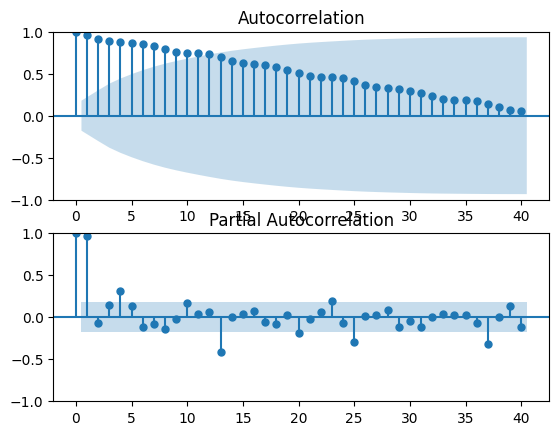

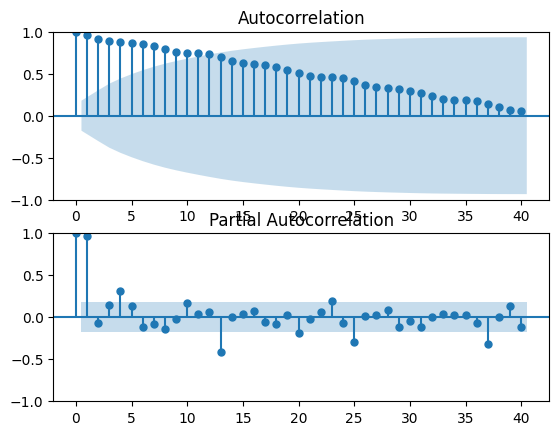

In [8]:
import matplotlib.pyplot as plt

N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1)
plot_acf(df["unemp_rate"], ax=ax[0], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df["unemp_rate"], ax=ax[1], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\cpi\__init__.py:109: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if year_or_month == to:


<AxesSubplot: title={'center': 'Gold Price (deflated)'}, xlabel='Date'>

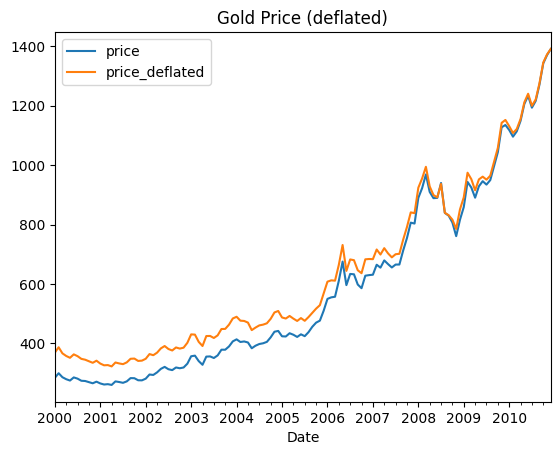

In [9]:
#Correcting for stationarity in time series
import pandas as pd
import numpy as np
import nasdaqdatalink
import cpi
from datetime import date

nasdaqdatalink.ApiConfig.api_key = "uLwMFhygQHyTJGEJ6QM3"

df = (
 nasdaqdatalink.get(dataset="WGC/GOLD_MONAVG_USD",
 start_date="2000-01-01",
 end_date="2010-12-31")
 .rename(columns={"Value": "price"})
 .resample("M")
 .last()
)

DEFL_DATE = date(2010, 12, 31)
df["dt_index"] = pd.to_datetime(df.index)
df["price_deflated"] = df.apply(
 lambda x: cpi.inflate(x["price"], x["dt_index"], DEFL_DATE), 
 axis=1
)
(
 df.loc[:, ["price", "price_deflated"]]
 .plot(title="Gold Price (deflated)")
)

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>], dtype=object)

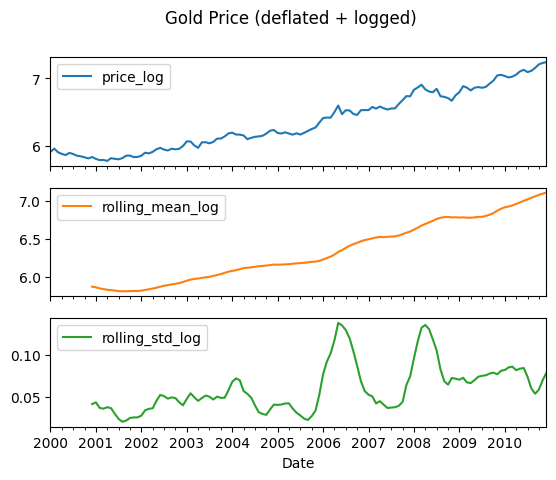

In [10]:
WINDOW = 12
selected_columns = ["price_log", "rolling_mean_log",
 "rolling_std_log"]
df["price_log"] = np.log(df.price_deflated)
df["rolling_mean_log"] = df.price_log.rolling(WINDOW) \
 .mean()
df["rolling_std_log"] = df.price_log.rolling(WINDOW) \
 .std()
(
 df[selected_columns]
 .plot(title="Gold Price (deflated + logged)", 
 subplots=True)
)

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


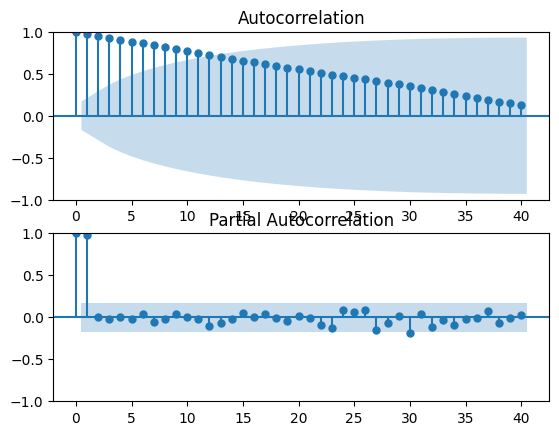

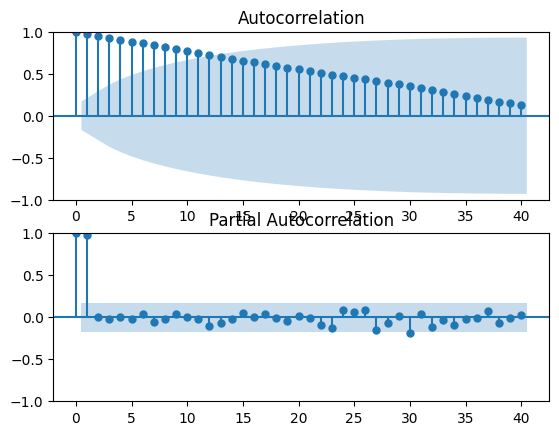

In [11]:

N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig1, ax1 = plt.subplots(2,1)
plot_acf(df["price_log"], ax=ax1[0], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df["price_log"], ax=ax1[1], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)

In [12]:
adf_test(df["price_log"])

Test Statistic              1.042266
p-value                     0.994692
# of Lags Used              0.000000
# of Observations Used    131.000000
Critical Value (1%)        -3.481282
Critical Value (5%)        -2.883868
Critical Value (10%)       -2.578677
dtype: float64

In [13]:
kpss_test(df["price_log"])

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic           1.932405
p-value                  0.010000
# of Lags                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

<AxesSubplot: title={'center': 'Gold Price (deflated + log + diff)'}, xlabel='Date'>

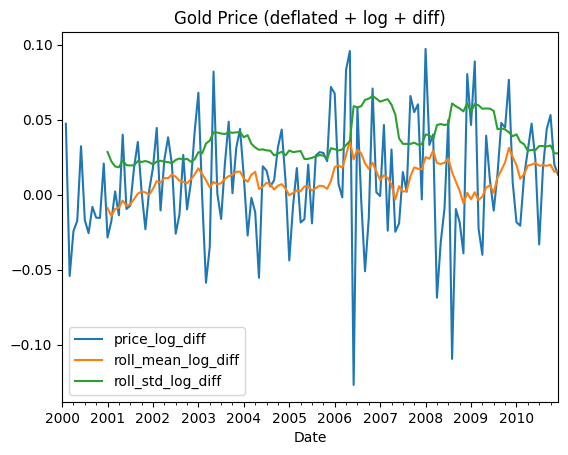

In [14]:
'''
deflation and a natural algorithm were not enough to make the time series of monthly 
gold prices stationary.
So we should apply differencing to the series and plot the results:
'''

selected_columns = ["price_log_diff", "roll_mean_log_diff",
 "roll_std_log_diff"]
df["price_log_diff"] = df.price_log.diff(1)
df["roll_mean_log_diff"] = df.price_log_diff.rolling(WINDOW) \
 .mean()
df["roll_std_log_diff"] = df.price_log_diff.rolling(WINDOW) \
 .std()
df[selected_columns].plot(title="Gold Price (deflated + log + diff)")
#the series oscillates around 0 with no visible trend and approximately constant variance.

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


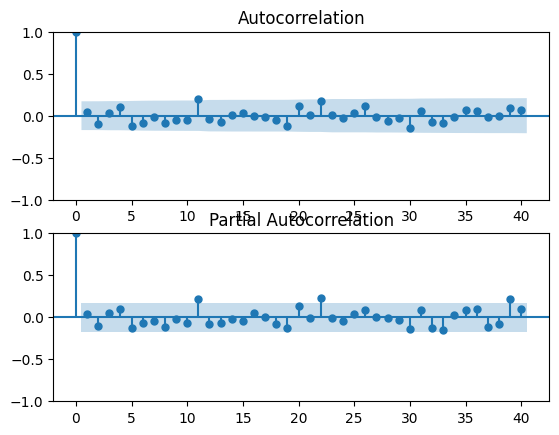

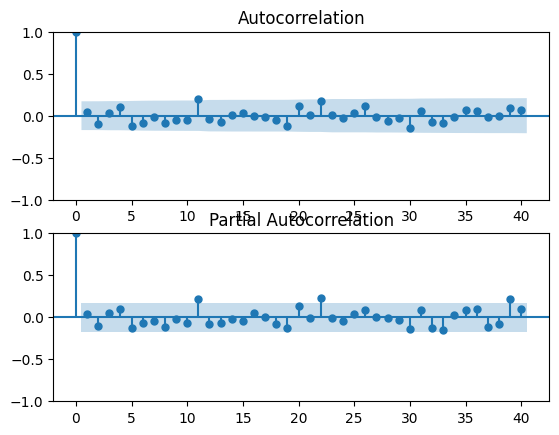

In [15]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig2, ax2 = plt.subplots(2,1)
plot_acf(df["price_log_diff"].dropna(), ax=ax2[0], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df["price_log_diff"].dropna(), ax=ax2[1], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)

In [16]:
adf_test(df["price_log_diff"].dropna())


Test Statistic           -1.086960e+01
p-value                   1.379277e-19
# of Lags Used            0.000000e+00
# of Observations Used    1.300000e+02
Critical Value (1%)      -3.481682e+00
Critical Value (5%)      -2.884042e+00
Critical Value (10%)     -2.578770e+00
dtype: float64

In [17]:
kpss_test(df["price_log_diff"].dropna())

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic           0.303875
p-value                  0.100000
# of Lags                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

In [18]:
#Modeling time series with exponential smoothing methods

'''
several models:
1.SES-> time series does not exhibit any trend or seasonality
2.Holt's linear trend method-> time series has a trend withoud seasonality
3. Holt-Winters’ seasonal smoothing+ additive seasonalities:
     the seasonal variations are more or less constant throughout the time series 
4. Holt-Winters’ seasonal smoothing+ multiplicative seasonalities: 
      the variations change in proportion to the passing of time.

'''
import pandas as pd
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing,  
                                         SimpleExpSmoothing,
                                         Holt)

nasdaqdatalink.ApiConfig.api_key = "uLwMFhygQHyTJGEJ6QM3"
df = (
 nasdaqdatalink.get(dataset="FRED/UNRATENSA",
 start_date="2010-01-01",
 end_date="2019-12-31")
 .rename(columns={"Value": "unemp_rate"})
)

TEST_LENGTH = 12
df.index.freq = "MS"
df_train = df.iloc[:-TEST_LENGTH]
df_test = df[-TEST_LENGTH:]
ses_1 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.5)
ses_forecast_1 = ses_1.forecast(TEST_LENGTH)
ses_2 = SimpleExpSmoothing(df_train).fit()
ses_forecast_2 = ses_2.forecast(TEST_LENGTH)
ses_1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.500000,False
initial_level,l.0,10.358112,True


C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\2196693662.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ses_df["ses_1"] = ses_1.fittedvalues.append(ses_forecast_1)
C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\2196693662.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ses_df["ses_2"] = ses_2.fittedvalues.append(ses_forecast_2)


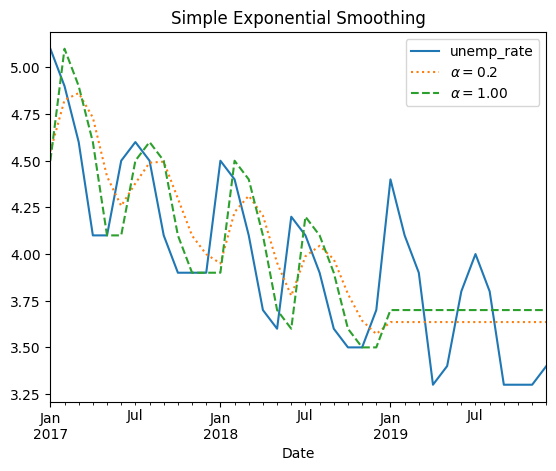

In [19]:
#SES model
ses_df = df.copy()
ses_df["ses_1"] = ses_1.fittedvalues.append(ses_forecast_1)
ses_df["ses_2"] = ses_2.fittedvalues.append(ses_forecast_2)
opt_alpha = ses_2.model.params["smoothing_level"]
fig, ax = plt.subplots()
ses_df["2017":].plot(style=["-",":","--"], ax=ax,
 title="Simple Exponential Smoothing")
labels = [
 "unemp_rate",
 r"$\alpha=0.2$",
 r'$\alpha={0:.2f}$'.format(opt_alpha),
]
ax.legend(labels)

C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\1120983601.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hs_df["hs_1"] = hs_1.fittedvalues.append(hs_forecast_1)
C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\1120983601.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hs_df["hs_2"] = hs_2.fittedvalues.append(hs_forecast_2)
C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\1120983601.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hs_df["hs_3"] = hs_3.fittedvalues.append(hs_forecast_3)


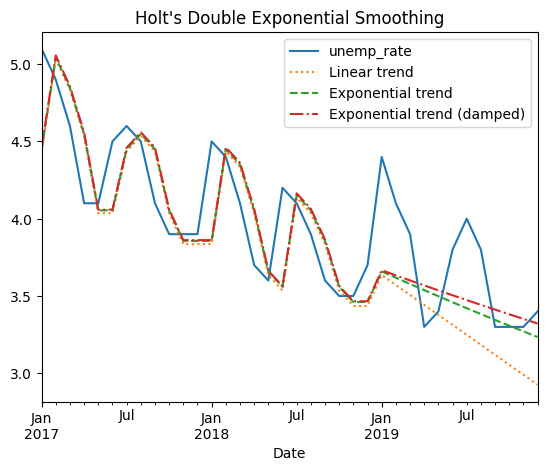

In [20]:
# Holt's model with linear trend
hs_1 = Holt(df_train).fit()
hs_forecast_1 = hs_1.forecast(TEST_LENGTH)
# Holt's model with exponential trend
hs_2 = Holt(df_train, exponential=True).fit()
hs_forecast_2 = hs_2.forecast(TEST_LENGTH)
# Holt's model with exponential trend and damping
hs_3 = Holt(df_train, exponential=False,
 damped_trend=True).fit()
hs_forecast_3 = hs_3.forecast(TEST_LENGTH)
hs_df = df.copy()
hs_df["hs_1"] = hs_1.fittedvalues.append(hs_forecast_1)
hs_df["hs_2"] = hs_2.fittedvalues.append(hs_forecast_2)
hs_df["hs_3"] = hs_3.fittedvalues.append(hs_forecast_3)
fig, ax = plt.subplots()
hs_df["2017":].plot(style=["-",":","--", "-."], ax=ax,
 title="Holt's Double Exponential Smoothing")
labels = [
 "unemp_rate",
 "Linear trend",
 "Exponential trend",
 "Exponential trend (damped)",
]
ax.legend(labels)

C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\3683747386.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hw_df["hw_1"] = hw_1.fittedvalues.append(hw_forecast_1)
C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\3683747386.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hw_df["hw_2"] = hw_2.fittedvalues.append(hw_forecast_2)


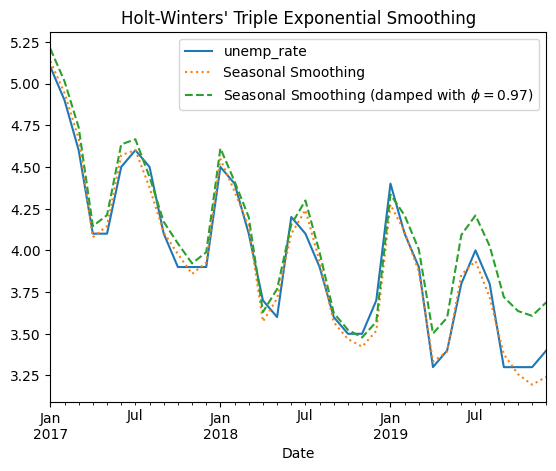

In [21]:
#Fit two variants of 
#Holt-Winters’ Triple Exponential Smoothing models and calculate the forecasts:
SEASONAL_PERIODS = 12
# Holt-Winters' model with exponential trend
hw_1 = ExponentialSmoothing(df_train,
 trend="mul",
 seasonal="add",
 seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(TEST_LENGTH)
# Holt-Winters' model with exponential trend and damping
hw_2 = ExponentialSmoothing(df_train,
 trend="mul",
 seasonal="add",
 seasonal_periods=SEASONAL_PERIODS,
 damped_trend=True).fit()
hw_forecast_2 = hw_2.forecast(TEST_LENGTH)
hw_df = df.copy()
hw_df["hw_1"] = hw_1.fittedvalues.append(hw_forecast_1)
hw_df["hw_2"] = hw_2.fittedvalues.append(hw_forecast_2)
fig, ax = plt.subplots()
hw_df["2017":].plot(
 style=["-",":","--"], ax=ax,
 title="Holt-Winters' Triple Exponential Smoothing"
)
phi = hw_2.model.params["damping_trend"]
labels = [
 "unemp_rate",
 "Seasonal Smoothing",
 f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)"
]
ax.legend(labels)

C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\766083554.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(auto_ets_fcst["unemp_rate"])


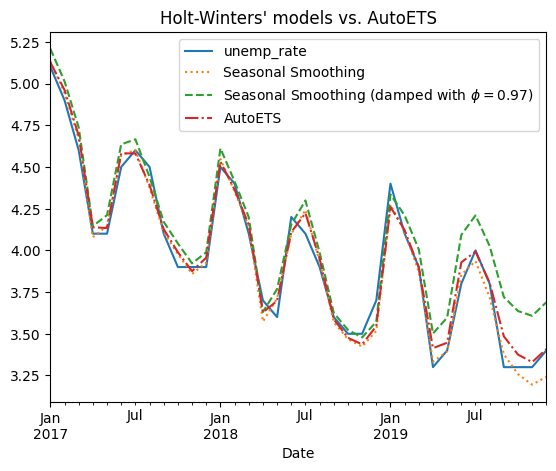

In [22]:
#another way to build this kind of model
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_percentage_error
auto_ets = AutoETS(auto=True, n_jobs=-1, sp=12)
auto_ets.fit(df_train.to_period())
auto_ets_fcst = auto_ets.predict(fh=list(range(1, 13)))

auto_ets_df = hw_df.to_period().copy()
auto_ets_df["auto_ets"] = (
 auto_ets
 ._fitted_forecaster
 .fittedvalues
 .append(auto_ets_fcst["unemp_rate"])
)

fig, ax = plt.subplots()
auto_ets_df["2017":].plot(
 style=["-",":","--","-."], ax=ax,
 title="Holt-Winters' models vs. AutoETS"
)
labels = [
 "unemp_rate",
 "Seasonal Smoothing",
 f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)",
 "AutoETS",
]
ax.legend(labels)

C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\1496651214.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["unemp_rate_log"] = np.log(df_train["unemp_rate"])
C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\1496651214.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["first_diff"] = df_train["unemp_rate_log"].diff()


array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>], dtype=object)

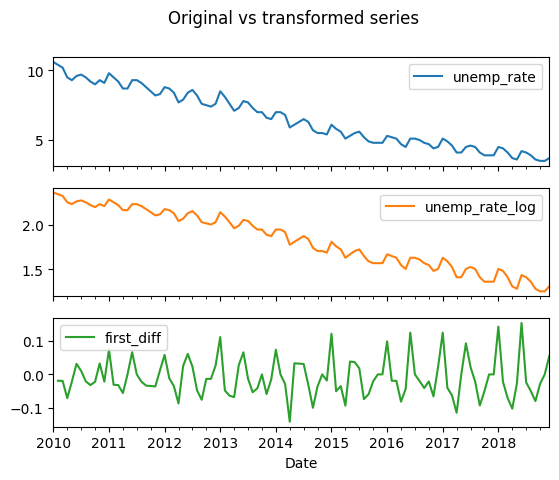

In [23]:
#Modeling time series with ARIMA class models
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

nasdaqdatalink.ApiConfig.api_key = "uLwMFhygQHyTJGEJ6QM3"
df = (
 nasdaqdatalink.get(dataset="FRED/UNRATENSA",
 start_date="2010-01-01",
 end_date="2019-12-31")
 .rename(columns={"Value": "unemp_rate"})
)

TEST_LENGTH = 12
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]
df_train["unemp_rate_log"] = np.log(df_train["unemp_rate"])
df_train["first_diff"] = df_train["unemp_rate_log"].diff()
df_train.plot(subplots=True, 
 title="Original vs transformed series")

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


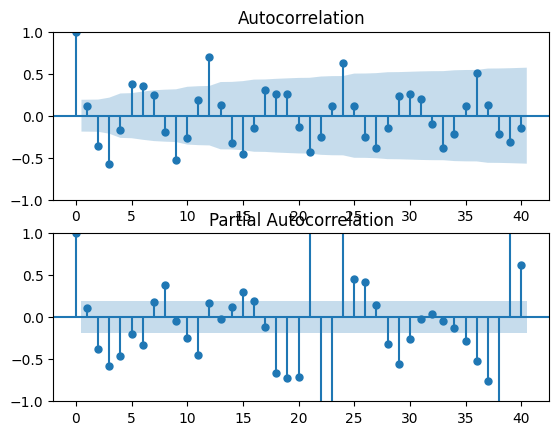

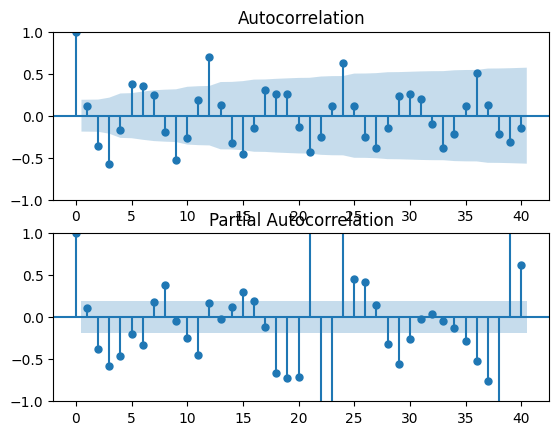

In [24]:

N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig2, ax2 = plt.subplots(2,1)
plot_acf(df_train["first_diff"].dropna(), ax=ax2[0], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df_train["first_diff"].dropna(), ax=ax2[1], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)

In [25]:
adf_test(df_train["first_diff"].dropna())

Test Statistic            -2.968824
p-value                    0.037910
# of Lags Used            11.000000
# of Observations Used    95.000000
Critical Value (1%)       -3.501137
Critical Value (5%)       -2.892480
Critical Value (10%)      -2.583275
dtype: float64

In [26]:
kpss_test(df_train["first_diff"].dropna())
#  the first differences of the log transformed series are stationary

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic           0.041407
p-value                  0.100000
# of Lags                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

In [27]:
arima_111 = ARIMA(
 df_train["unemp_rate_log"], order=(1, 1, 1)
).fit()
arima_111.summary()

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unemp_rate_log   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 157.020
Date:                Thu, 20 Apr 2023   AIC                           -308.040
Time:                        22:18:01   BIC                           -300.021
Sample:                    01-01-2010   HQIC                          -304.789
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5541      0.401      1.381      0.167      -0.232       1.341
ma.L1         -0.7314      0.306     -2.391      0.017      -1.331      -0.132
sigma2         0.0031      0.000      6.823      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   2.55   Jarque-Bera (JB):                 9.59
Prob(Q):                              0.11   Prob(JB):                         0.01
Heteroskedasticity (H):               2.33   Skew:                             0.64
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
arima_212 = ARIMA(
 df_train["unemp_rate_log"], order=(2, 1, 2)
).fit()
arima_212.summary()

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unemp_rate_log   No. Observations:                  108
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 196.744
Date:                Thu, 20 Apr 2023   AIC                           -383.488
Time:                        22:18:02   BIC                           -370.124
Sample:                    01-01-2010   HQIC                          -378.070
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9952      0.014     69.779      0.000       0.967       1.023
ar.L2         -0.9894      0.014    -70.303      0.000      -1.017      -0.962
ma.L1         -1.1435     38.247     -0.030      0.976     -76.105      73.818
ma.L2          1.0000     66.899      0.015      0.988    -130.119     132.119
sigma2         0.0014      0.091      0.015      0.988      -0.178       0.180
===================================================================================
Ljung-Box (L1) (Q):                  11.33   Jarque-Bera (JB):                 3.24
Prob(Q):                              0.00   Prob(JB):                         0.20
Heteroskedasticity (H):               1.99   Skew:                             0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
df["pred_111_log"] = (
 arima_111
 .fittedvalues
 .append(arima_111.forecast(TEST_LENGTH))
)
df["pred_111"] = np.exp(df["pred_111_log"])
df["pred_212_log"] = (
 arima_212
 .fittedvalues
 .append(arima_212.forecast(TEST_LENGTH))
)
df["pred_212"] = np.exp(df["pred_212_log"])
df

C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\2698061094.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(arima_111.forecast(TEST_LENGTH))
C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\2698061094.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(arima_212.forecast(TEST_LENGTH))


,unemp_rate,pred_111_log,pred_111,pred_212_log,pred_212
Date,,,,,
2010-01-01,10.6,0.000000,1.000000,0.000000,1.000000
2010-02-01,10.4,2.360854,10.600000,2.360854,10.600000
2010-03-01,10.2,2.344579,10.428876,2.337648,10.356851
2010-04-01,9.5,2.327490,10.252181,2.324145,10.217941
2010-05-01,9.3,2.266961,9.650034,2.256301,9.547705
...,...,...,...,...,...
2019-08-01,3.8,1.308395,3.700231,1.340892,3.822453
2019-09-01,3.3,1.308395,3.700232,1.272457,3.569614
2019-10-01,3.3,1.308396,3.700232,1.222059,3.394169


<AxesSubplot: title={'center': 'ARIMA forecast of the US unemployment rate'}, xlabel='Date'>

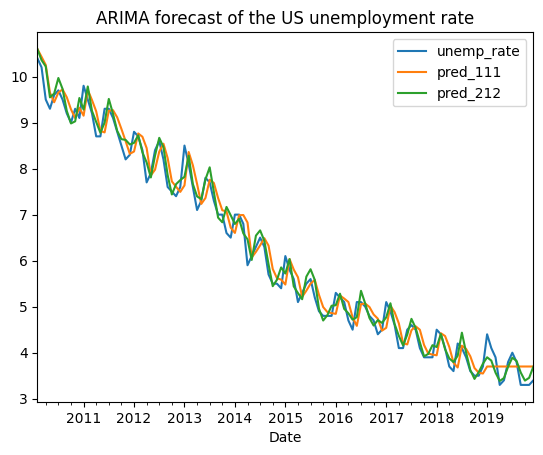

In [30]:
(
 df[["unemp_rate", "pred_111", "pred_212"]]
 .iloc[1:]
 .plot(title="ARIMA forecast of the US unemployment rate")
)

<AxesSubplot: title={'center': 'Zooming in on the out-of-sample forecast'}, xlabel='Date'>

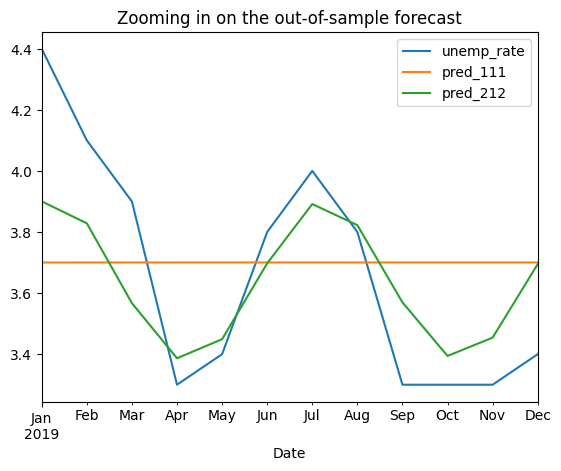

In [31]:

(
 df[["unemp_rate", "pred_111", "pred_212"]]
 .iloc[-TEST_LENGTH:]
 .plot(title="Zooming in on the out-of-sample forecast")
)

In [32]:
mape_111 = mean_absolute_percentage_error(
 df["unemp_rate"].iloc[-TEST_LENGTH:],
 df["pred_111"].iloc[-TEST_LENGTH:]
)
mape_212 = mean_absolute_percentage_error(
 df["unemp_rate"].iloc[-TEST_LENGTH:],
 df["pred_212"].iloc[-TEST_LENGTH:]
)
print(f"MAPE of ARIMA(1,1,1): {100 * mape_111:.2f}%")
print(f"MAPE of ARIMA(2,1,2): {100 * mape_212:.2f}%")

MAPE of ARIMA(1,1,1): 9.14%
MAPE of ARIMA(2,1,2): 5.08%


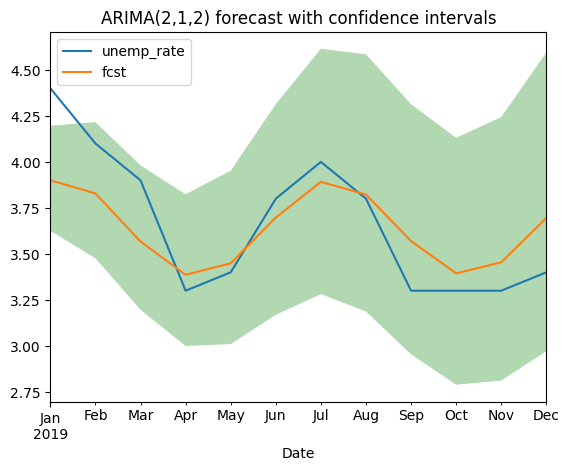

In [33]:
preds_df = arima_212.get_forecast(TEST_LENGTH).summary_frame()
preds_df.columns = ["fcst", "fcst_se", "ci_lower", "ci_upper"]
plot_df = df_test[["unemp_rate"]].join(np.exp(preds_df))
fig, ax = plt.subplots()
(
 plot_df[["unemp_rate", "fcst"]]
 .plot(ax=ax,
 title="ARIMA(2,1,2) forecast with confidence intervals")
)
ax.fill_between(plot_df.index,
 plot_df["ci_lower"],
 plot_df["ci_upper"],
 alpha=0.3,
 facecolor="g")
ax.legend(loc="upper left")

In [34]:
#Finding the best-fitting ARIMA model with auto-ARIMA
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

nasdaqdatalink.ApiConfig.api_key = "uLwMFhygQHyTJGEJ6QM3"
df = (
 nasdaqdatalink.get(dataset="FRED/UNRATENSA",
 start_date="2010-01-01",
 end_date="2019-12-31")
 .rename(columns={"Value": "unemp_rate"})
)

TEST_LENGTH = 12
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

auto_arima = pm.auto_arima(df_train,
 test="adf",
 seasonal=False,
 with_intercept=False,
 stepwise=True,
 suppress_warnings=True,
 trace=True)
 
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7.411, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.864, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=77.461, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=75.688, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=68.551, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=54.321, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=7.458, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=7.153, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=60.069, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=10.492, Time=0.46 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25.922, Time=0.41 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 3.591 seco

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(2, 1, 3)   Log Likelihood                   2.423
Date:                Thu, 20 Apr 2023   AIC                              7.153
Time:                        22:18:07   BIC                             23.190
Sample:                    01-01-2010   HQIC                            13.654
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0040      0.007    134.211      0.000       0.989       1.019
ar.L2         -0.9970      0.004   -242.026      0.000      -1.005      -0.989
ma.L1         -1.2894      0.113    -11.392      0.000      -1.511      -1.068
ma.L2          1.2149      0.170      7.163      0.000       0.882       1.547
ma.L3         -0.2161      0.103     -2.108      0.035      -0.417      -0.015
sigma2         0.0525      0.010      5.302      0.000       0.033       0.072
===================================================================================
Ljung-Box (L1) (Q):                   2.77   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.10   Prob(JB):                         0.49
Heteroskedasticity (H):               0.48   Skew:                             0.27
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

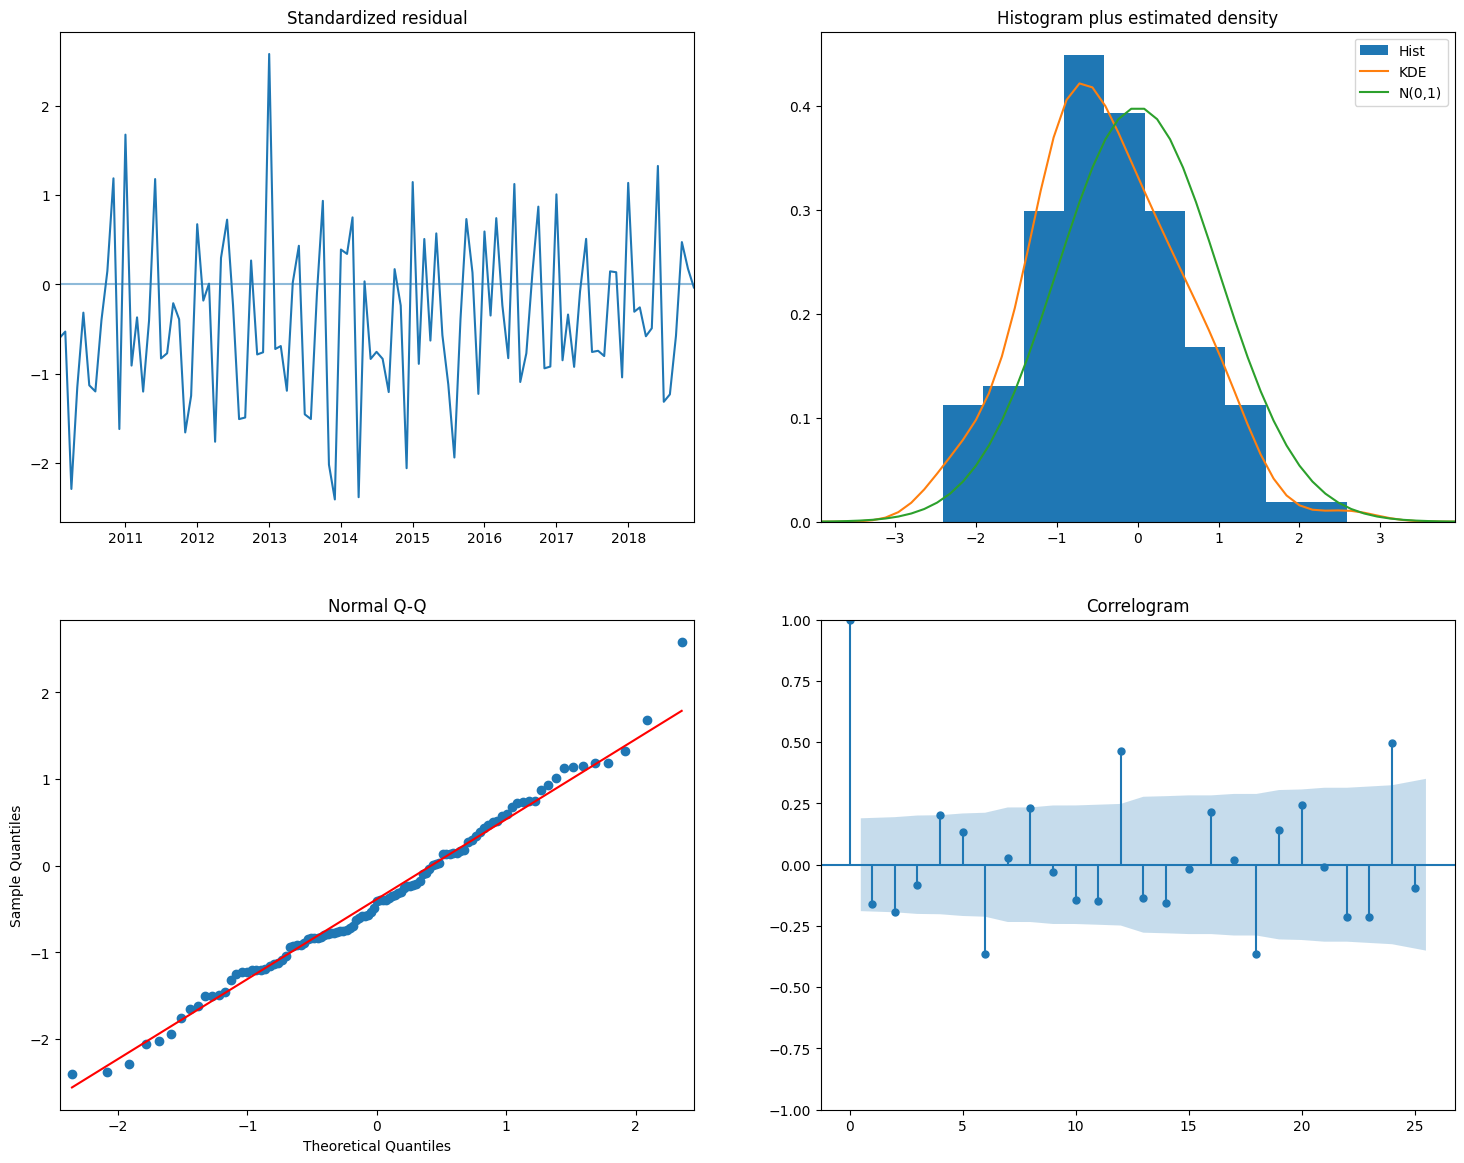

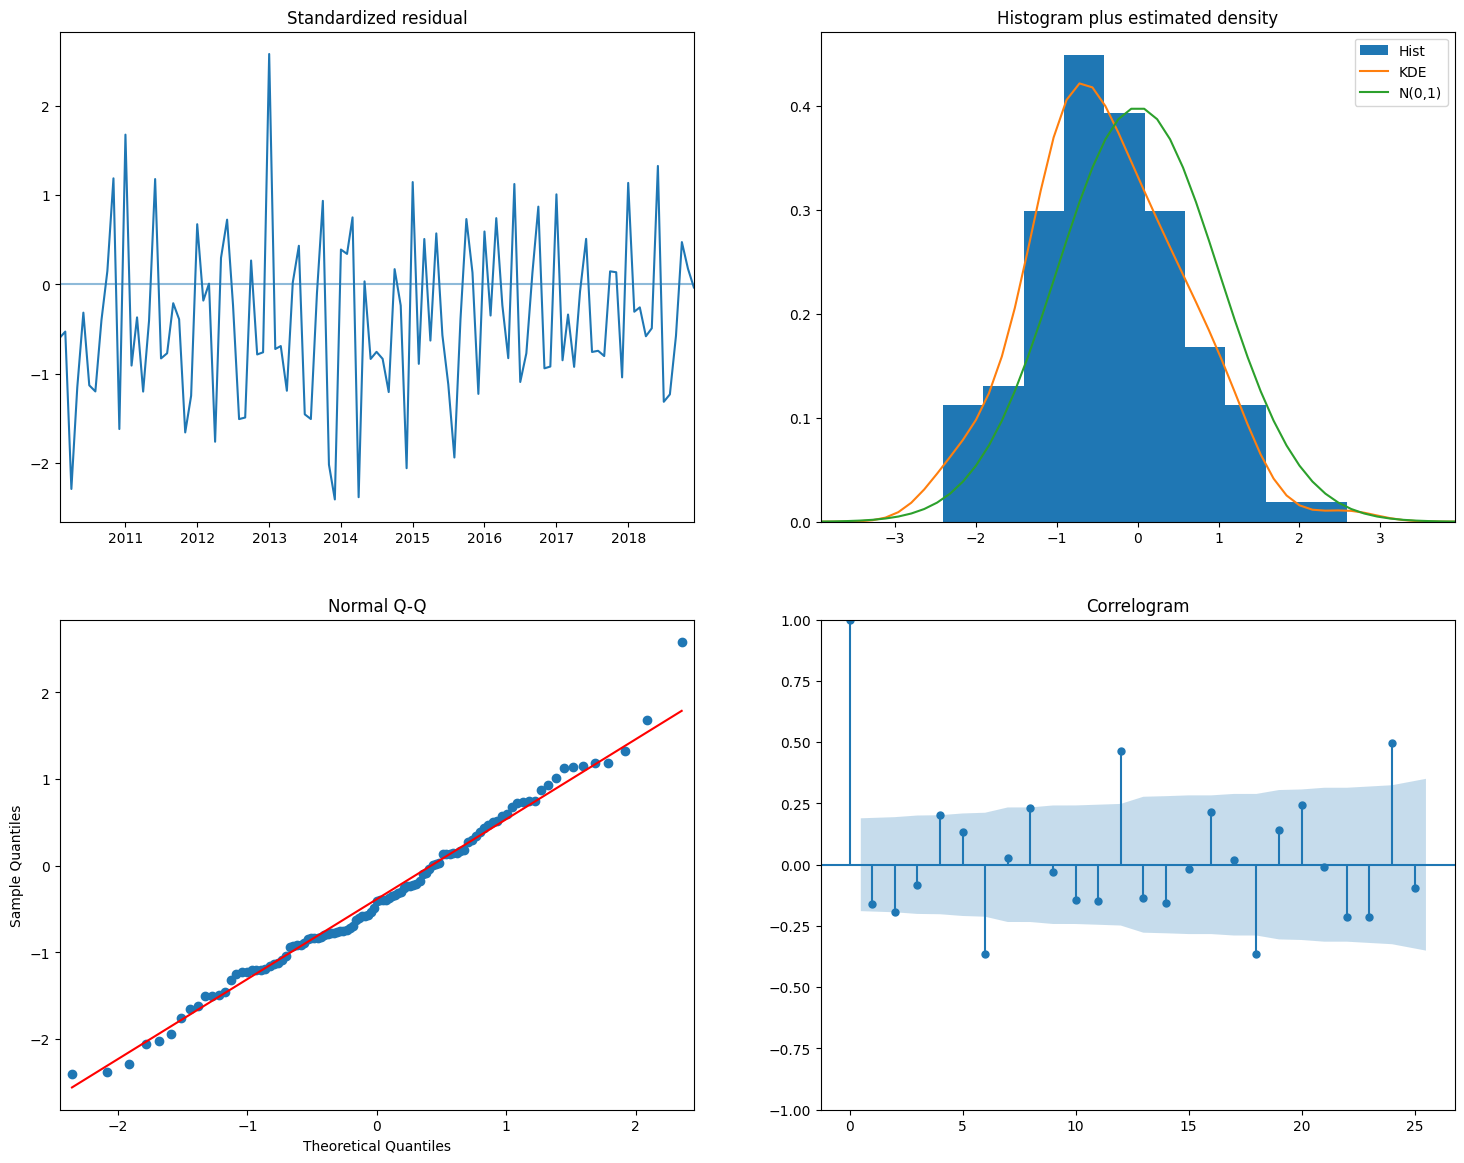

In [35]:
auto_arima.plot_diagnostics(figsize=(18, 14), lags=25)

In [40]:
auto_sarima = pm.auto_arima(df_train,
 test="adf",
 seasonal=True,
 m=12,
 with_intercept=False,
 stepwise=True,
 suppress_warnings=True,
 trace=True)
auto_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=77.864, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-19.349, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=39.115, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=77.461, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=39.307, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-19.382, Time=0.07 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=37.495, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=-22.056, Time=0.14 sec


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  108
Model:             SARIMAX(0, 1, 5)x(1, 0, [1, 2], 12)   Log Likelihood                  40.965
Date:                                 Thu, 20 Apr 2023   AIC                            -63.930
Time:                                         22:21:17   BIC                            -39.875
Sample:                                     01-01-2010   HQIC                           -54.178
                                          - 12-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2866      0.113     -2.531      0.011      -0.509      -0.065
ma.L2         -0.1162      0.108     -1.076      0.282      -0.328       0.095
ma.L3         -0.2114      0.124     -1.698      0.089      -0.455       0.033
ma.L4          0.0780      0.126      0.619      0.536      -0.169       0.325
ma.L5          0.2451      0.103      2.387      0.017       0.044       0.446
ar.S.L12       0.9984      0.012     84.057      0.000       0.975       1.022
ma.S.L12      -1.0085      0.328     -3.077      0.002      -1.651      -0.366
ma.S.L24       0.1108      0.134      0.824      0.410      -0.153       0.374
sigma2         0.0196      0.006      3.095      0.002       0.007       0.032
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.64   Prob(JB):                         0.35
Heteroskedasticity (H):               0.61   Skew:                            -0.30
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

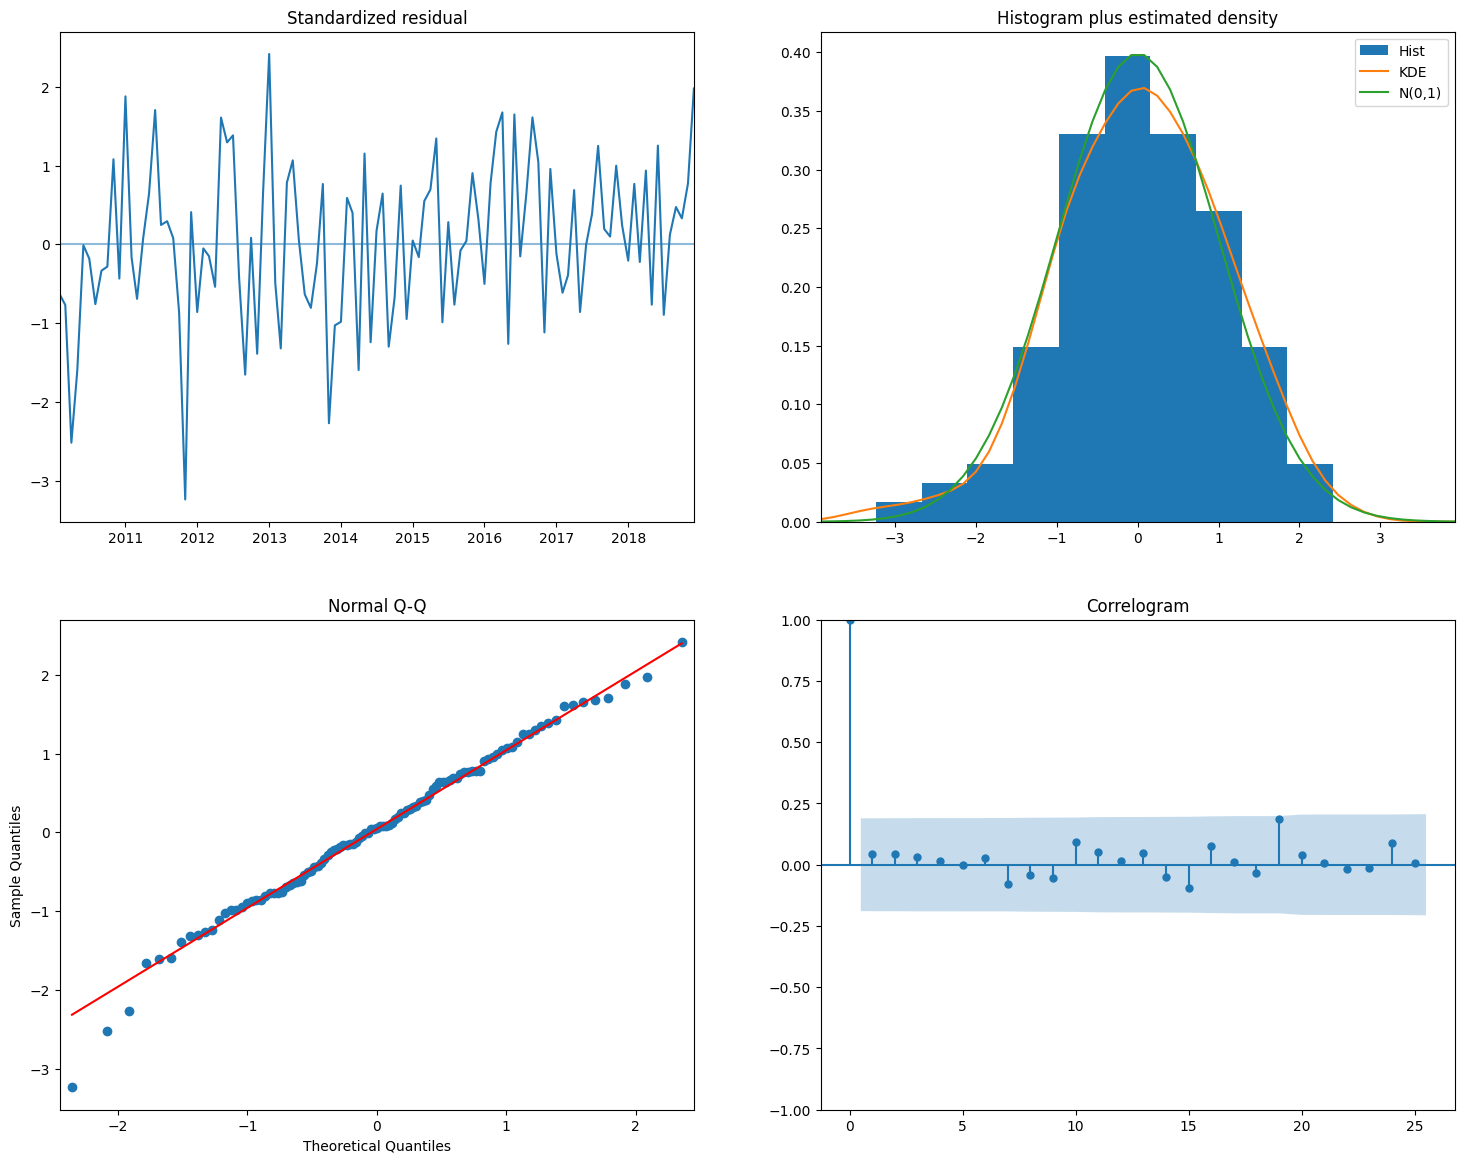

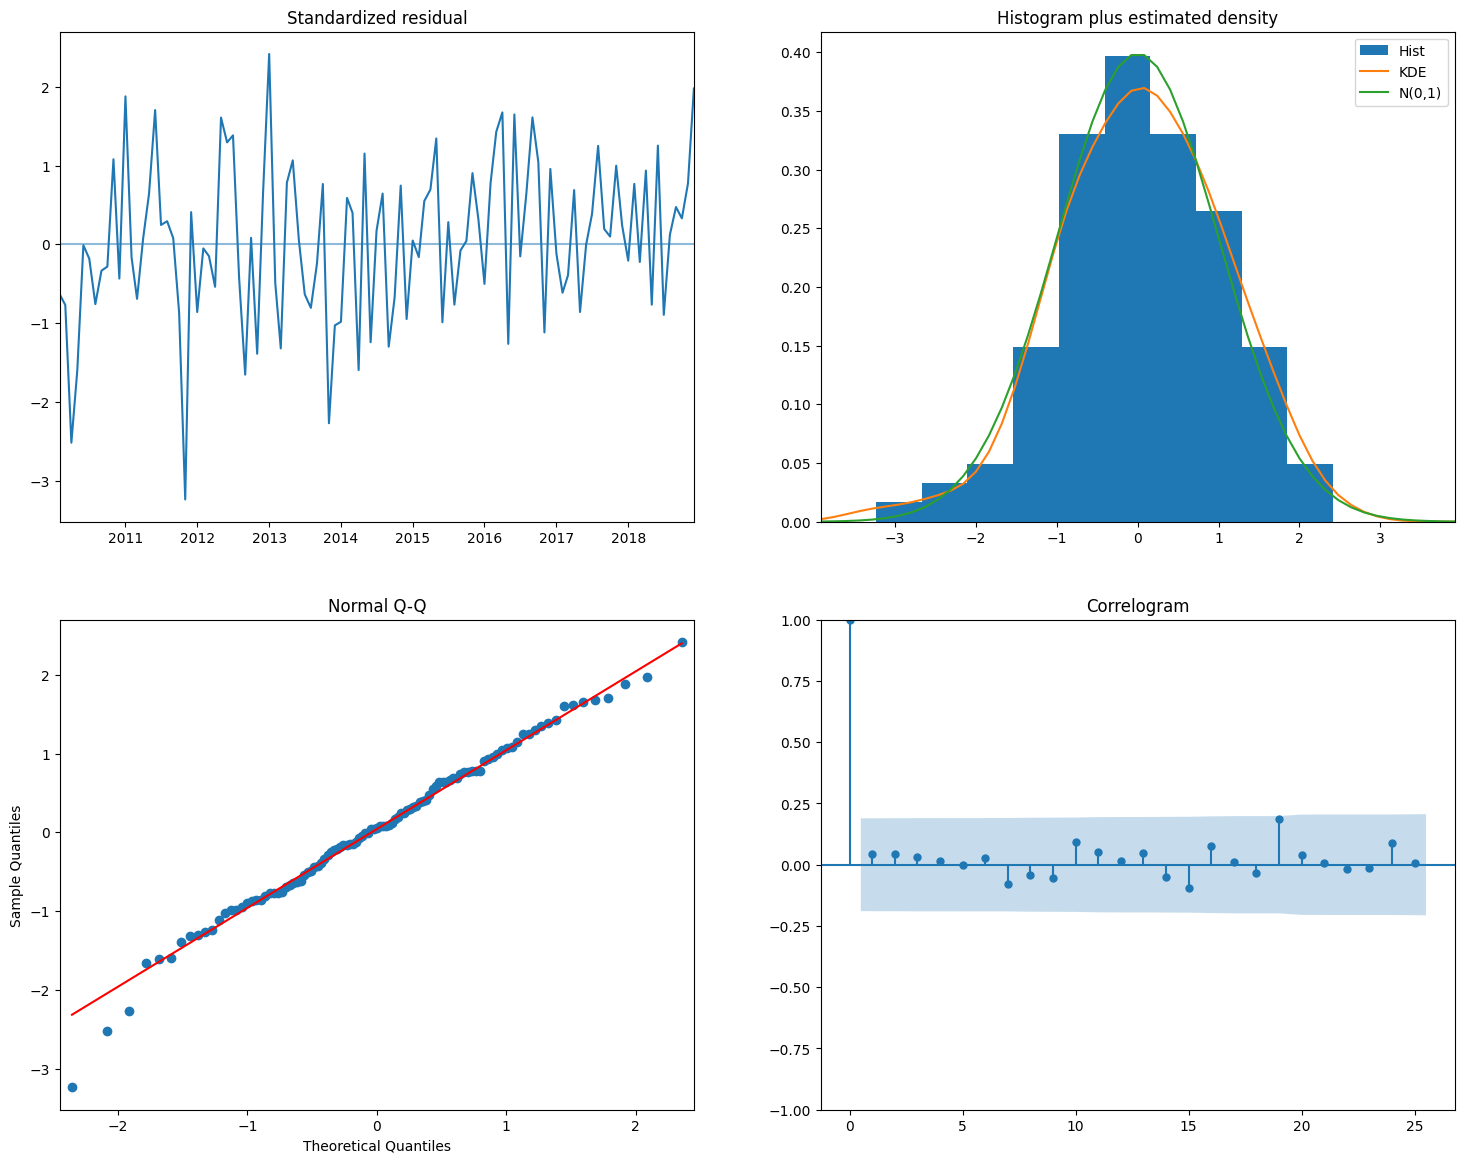

In [41]:
auto_sarima.plot_diagnostics(figsize=(18, 14), lags=25)

C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\3985653910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["auto_arima"] = auto_arima.predict(TEST_LENGTH)
C:\Users\Jackson\AppData\Local\Temp\ipykernel_18256\3985653910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["auto_sarima"] = auto_sarima.predict(TEST_LENGTH)


<AxesSubplot: title={'center': 'Forecasts of the best ARIMA/SARIMA models'}, xlabel='Date'>

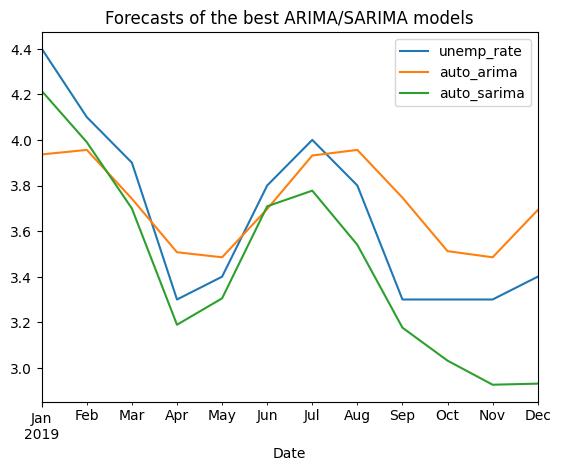

In [42]:
df_test["auto_arima"] = auto_arima.predict(TEST_LENGTH)
df_test["auto_sarima"] = auto_sarima.predict(TEST_LENGTH)
df_test.plot(title="Forecasts of the best ARIMA/SARIMA models")

In [43]:
mape_auto_arima = mean_absolute_percentage_error(
    df_test["unemp_rate"], 
    df_test["auto_arima"]
)
mape_auto_sarima = mean_absolute_percentage_error(
    df_test["unemp_rate"], 
    df_test["auto_sarima"]
)
print(f"MAPE of auto-ARIMA: {100*mape_auto_arima:.2f}%")
print(f"MAPE of auto-SARIMA: {100*mape_auto_sarima:.2f}%")

MAPE of auto-ARIMA: 5.80%
MAPE of auto-SARIMA: 5.83%
